# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [1]:
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [8]:
import os
import fitz  # PyMuPDF

# Kombiniert den Text aus allen PDFs im Ordner "data"
pdf_text = ""

for filename in os.listdir("data"):
    if filename.endswith(".pdf"):
        with fitz.open(os.path.join("data", filename)) as doc:
            for page in doc:
                pdf_text += page.get_text() + "\n"

# Speichert den kombinierten Text in eine Datei
with open("combined_text.txt", "w", encoding="utf-8") as f:
    f.write(pdf_text)

# Gibt die ersten 500 Zeichen aus
print(pdf_text)


Hypertension in adults: 
diagnosis and management 
NICE guideline 
Published: 28 August 2019 
Last updated: 21 November 2023 
www.nice.org.uk/guidance/ng136 
© NICE 2024. All rights reserved. Subject to Notice of rights (https://www.nice.org.uk/terms-and-
conditions#notice-of-rights).

Your responsibility 
The recommendations in this guideline represent the view of NICE, arrived at after careful 
consideration of the evidence available. When exercising their judgement, professionals 
and practitioners are expected to take this guideline fully into account, alongside the 
individual needs, preferences and values of their patients or the people using their service. 
It is not mandatory to apply the recommendations, and the guideline does not override the 
responsibility to make decisions appropriate to the circumstances of the individual, in 
consultation with them and their families and carers or guardian. 
All problems (adverse events) related to a medicine or medical device used for t

"""
## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.
"""

In [7]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters

from langchain.text_splitter import RecursiveCharacterTextSplitter

# Funktion zum Aufteilen des Textes in überlappende Chunks
def split_text_into_chunks(text, chunk_size=2000, overlap=200):
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size, 
        chunk_overlap=overlap
    )
    chunks = text_splitter.split_text(text)
    return chunks

# Angenommen, der extrahierte Text wurde vorher in `pdf_text` gespeichert
chunks = split_text_into_chunks(pdf_text)

# Ausgabe der ersten 3 Chunks zur Kontrolle
for i, chunk in enumerate(chunks[:3]):
    print(f"Chunk {i+1}:\n{chunk}\n")
    
print(f"Gesamtanzahl der Chunks: {len(chunks)}")



Chunk 1:
Hypertension in adults: 
diagnosis and management 
NICE guideline 
Published: 28 August 2019 
Last updated: 21 November 2023 
www.nice.org.uk/guidance/ng136 
© NICE 2024. All rights reserved. Subject to Notice of rights (https://www.nice.org.uk/terms-and-
conditions#notice-of-rights).

Chunk 2:
Your responsibility 
The recommendations in this guideline represent the view of NICE, arrived at after careful 
consideration of the evidence available. When exercising their judgement, professionals 
and practitioners are expected to take this guideline fully into account, alongside the 
individual needs, preferences and values of their patients or the people using their service. 
It is not mandatory to apply the recommendations, and the guideline does not override the 
responsibility to make decisions appropriate to the circumstances of the individual, in 
consultation with them and their families and carers or guardian. 
All problems (adverse events) related to a medicine or medical

In [10]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 155
Preview of the first chunk: Hypertension in adults: 
diagnosis and management 
NICE guideline 
Published: 28 August 2019 
Last updated: 21 November 2023 
www.nice.org.uk/guidance/ng136 
© NICE 2024. All rights reserved. Subject 


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model.

In [11]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [13]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 470
Hypertension in adults: diagnosis and management NICE guideline Published: 28 August 2019 Last updated: 21 November 2023 www.nice.org.uk/guidance/ng136 © NICE 2024. All rights reserved. Subject to Notice of rights (https://www.nice.org.uk/terms-and- conditions#notice-of-rights).


In [12]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁Hyper', 'tension', '▁in', '▁adults', ':', '▁', 'diagnos', 'is', '▁and', '▁management', '▁', 'NICE', '▁guide', 'line', '▁Published', ':', '▁28', '▁August', '▁2019', '▁Last', '▁updated', ':', '▁21', '▁November', '▁2023', '▁www', '.', 'nice', '.', 'org', '.', 'uk', '/', 'gui', 'dan', 'ce', '/', 'ng', '136', '▁©', '▁', 'NICE', '▁20', '24.', '▁All', '▁rights', '▁reserved', '.', '▁Subject', '▁to', '▁No', 'tice', '▁of', '▁rights', '▁(', 'https', '://', 'www', '.', 'nice', '.', 'org', '.', 'uk', '/', 'term', 's', '-', 'and', '-', '▁conditions', '#', 'no', 'tice', '-', 'of', '-', 'right', 's', ').', '</s>']
Chunk 1: ['<s>', '▁Your', '▁responsibility', '▁The', '▁recommendations', '▁in', '▁this', '▁guide', 'line', '▁represent', '▁the', '▁view', '▁of', '▁', 'NICE', ',', '▁arrived', '▁at', '▁after', '▁care', 'ful', '▁consideration', '▁of', '▁the', '▁evidence', '▁available', '.', '▁When', '▁exerci', 'sing', '▁their', '▁judge', 'ment', ',', '▁professionals', '▁and', '▁prac', 'ti', 

In [15]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', 'Hyper', '##tens', '##ion', 'in', 'ad', '##ult', '##s', ':', 'di', '##agno', '##sis', 'and', 'man', '##agement', 'N', '##IC', '##E', 'gu', '##ide', '##line', 'Publ', '##ished', ':', '28', 'August', '2019', 'Last', 'updated', ':', '21', 'November', '202', '##3', 'www', '.', 'ni', '##ce', '.', 'or', '##g', '.', 'u', '##k', '/', 'gu', '##ida', '##nc', '##e', '/', 'ng', '##13', '##6', '©', 'N', '##IC', '##E', '202', '##4', '.', 'All', 'ri', '##gh', '##ts', 'reserv', '##ed', '.', 'Sub', '##ject', 'to', 'Not', '##ice', 'of', 'ri', '##gh', '##ts', '(', 'https', ':', '/', '/', 'www', '.', 'ni', '##ce', '.', 'or', '##g', '.', 'u', '##k', '/', 'ter', '##ms', '-', 'and', '-', 'con', '##dition', '##s', '#', 'not', '##ice', '-', 'of', '-', 'ri', '##gh', '##ts', ')', '.', '[SEP]']
Chunk 1: ['[CLS]', 'Your', 'res', '##pon', '##sibil', '##ity', 'The', 're', '##comm', '##end', '##ations', 'in', 'this', 'gu', '##ide', '##line', 're', '##pres', '##ent', 'the', 'view', 'of', 'N', '##IC'

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [16]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

"""
## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.
"""

In [17]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [18]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 470


In [19]:
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [20]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

155
470


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [20]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [21]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/470 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/470 [00:01<14:13,  1.82s/it]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/si

Projected dataset embeddings shape: (470, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [32]:
def retrieve(query, k):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [33]:
query = "What is the most important stuff for asthma"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
no asthma attacks, no need for rescue medication, no limitations on activity including exercise, normal lung function (in practical terms forced expiratory volume in 1 second [FEV1] and/or peak expiratory flow [PEF] more than 80% predicted or best), and minimal side effects from treatment. Atopic di


In [34]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings: 100%|██████████| 1/1 [00:00<0

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

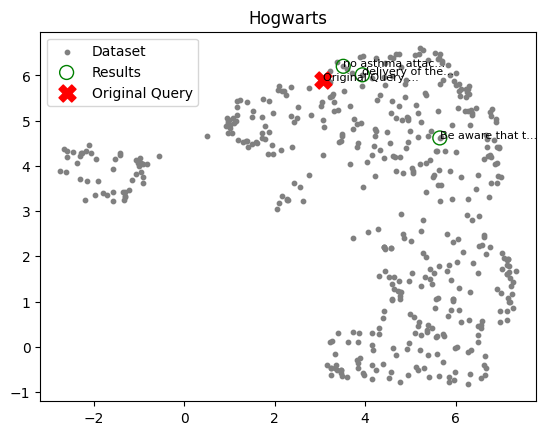

In [35]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Original Query Text'  # Replace with your actual query text if needed
plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Hogwarts')
plt.legend()
plt.show()


## Attach Retrieved Results to LLM

- Combine learnings from week 1 with approach from this week to inject your data into prompts and create a simple question answering system